# ACSE 4.4 - Identification Game with EfficientNet

### Initialization

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd /content/gdrive/"My Drive"/new

/content/gdrive/My Drive/new


In [0]:
!unzip data.zip -d /content && rm *.zip

#### Prepare for Plotting

In [0]:
!pip install pycm livelossplot
%pylab inline

In [0]:
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from livelossplot import PlotLosses
from pycm import *
import torch.nn as nn
import torch.nn.functional as F

## Initialize dataset
We provide two ways of initialize the dataset. The following one is by unzipping the file from beginning. You can choose one you prefer.

In [0]:
full_dataset = ImageFolder('/content/train', transforms.Compose([
            transforms.Resize(224),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
            # transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ]))
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transforms = transforms.Compose([transforms.Resize(224), transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=256, shuffle=True,
        num_workers=8, pin_memory=True)
val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=256, shuffle=True,
        num_workers=8, pin_memory=True)
train_all_loader = torch.utils.data.DataLoader(
        full_dataset, batch_size=256, shuffle=True,
        num_workers=8, pin_memory=True)

## Another faster way of initialization
These files are prepared in advance since it takes much time to transform imgs to Tensors. The detail of process of preparation is on the Data_preparation.ipynb.

In [0]:
X_train_all = torch.load('/content/drive/My Drive/data/X_train_all.py') # all images in train file
y_train_all = torch.load('/content/drive/My Drive/data/y_train_all.py') # all labels in train file
mean_list = torch.load('/content/drive/My Drive/data/mean_list.py') # mean
std_list = torch.load('/content/drive/My Drive/data/std_list.py') # std of 3 channels

#### Sanity check

In [0]:
print('Check the dataset')
print('X_train shape:',X_train_all.shape)
print('y_train shape:',y_train_all.shape)
print('mean of each channel:', mean_list)
print('standard deviation of each channel', std_list)
print('normalised data range(not standarized):', X_train_all.min().item(), '~', X_train_all.max().item())

Check the dataset
X_train shape: torch.Size([100000, 3, 64, 64])
y_train shape: torch.Size([100000])
mean of each channel: tensor([0.4802, 0.4481, 0.3975])
standard deviation of each channel tensor([0.2770, 0.2691, 0.2821])
normalised data range(not standarized): 0.0 ~ 1.0


### Stratify the dataset

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

# initialise the stratifiedshufflesplitter
# split the whole training dataset into 90% for training and 10% for validation
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42) 
spt = sss.split(X_train_all, y_train_all)
# get the indices of the splited data
indices = [(train_idx, validation_idx) for train_idx, validation_idx in spt][0]

In [0]:
# here the dataset is still in the form of np.array
X_train, y_train = X_train_all[indices[0]], y_train_all[indices[0]]
X_val, y_val = X_train_all[indices[1]], y_train_all[indices[1]]

#Check the size of the data set
print('90% training:', X_train.shape, X_val.shape)
print('10% validation:', y_train.shape, y_val.shape)
print('normalised data range(not standarized):', X_train_all.min().item(), '~', X_train_all.max().item())

### Create custom dataset

In [0]:
from torch.utils.data import Dataset
from PIL import Image

# Custom Dataset for performing Stratified Shuffle Split on ImageFolder datasets

class CustomDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            dataset: an ImageFolder containing the full set of data to be subsampled
            indices: array-like containing the stratified shuffle indices
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        # Note that samples are just paths to image files
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

### Data Augmentation
We resize the original pritures to 224*224 to fit the EfficientNet structure.

In [0]:
from torchvision.transforms import *

# Transformations
# As for this model, we have used pretrained model which has a fixed input
# pixel size of 224*224. We have resized the 64*64 pixels picture to 224*224

# Two types of data augmentation applied here:
# 1.randomly rotate by 10 degrees
# 2.flip horizontally with a probability of 0.5
train_transform = Compose([ToPILImage(),
              transforms.Resize(224),
              RandomRotation(10),
              RandomHorizontalFlip(p=0.5),
              ToTensor(),
              Normalize(mean_list, std_list)])

#In Validation and Test Mode we only want to normalize our images
validation_test_transform = Compose([ToPILImage(),
                    transforms.Resize(224),
                    ToTensor(),
                    Normalize(mean_list, std_list)])

### Create Dataloader for training and validation 

In [0]:
train_data = CustomDataset(X_train, y_train.long(), transform=train_transform)
val_data = CustomDataset(X_val, y_val.long(), transform=validation_test_transform)
train_all_data = CustomDataset(X_train_all, y_train_all.long(), transform=train_transform)

batch_size = 256
test_batch_size = 256
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=test_batch_size, shuffle=False, num_workers=2, pin_memory=True)
train_all_loader = torch.utils.data.DataLoader(train_all_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

## Initialize EfficientNet
We choose the most advanced CNN at the present day, the EfficientNet which was trained and tested on ImageNet.[1] https://arxiv.org/pdf/1905.11946.pdf By fixing the all the parameters in the exiting pretrained layers, we are keeping all the features that the network has learnt from the ImageNet. Then we added one new linear forward layer at the bottom of the network with a dropout layer to overcome the overfitting problem. Then we traines the parameters which would extract the feature from the 1000 output neurons to 200 classes. In this way, our new model's computational cost is acceptable, and the accuracy is expected to be good.

In [0]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
import torch.nn as nn
import torchvision.models as models

model = EfficientNet.from_pretrained('efficientnet-b7')
for name, param in model.named_parameters():
  param.requires_grad = False
model = nn.Sequential(model, nn.Dropout(p=0.4, inplace=False), nn.Linear(1000,200))
mdoel = model.cuda()
optimizer = torch.optim.Adam(model.parameters(),lr=2e-3, weight_decay=0.12)

# Firstly, we have tried the dynamic scheduler according to the change after each optimiser step
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=1, verbose=True, threshold=0.001, 
                                                       #threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
# It is not as good as using, but we find out that the learning stall about every 3 epochs
# We have then changed it to a StepLR scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=14a0e4c915643f0cd678f333b9664b2cf84d3d906ca013547063d97b1e12e8b6
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/checkpoints/efficientnet-b7-dcc49843.pth



Loaded pretrained weights for efficientnet-b7




---



### Preparing for training session

In [0]:
# This part are computing the accuracy. It is able to compute top-1 and top-5 accuracy if needed 
class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self, name, fmt=':f'):
    self.name = name
    self.fmt = fmt
    self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

  def __str__(self):
    fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
    return fmtstr.format(**self.__dict__)

def accuracy(output, target, topk=(1,)):
  """Computes the accuracy over the k top predictions for the specified values of k"""
  maxk = max(topk)
  batch_size = target.size(0)

  _, pred = output.topk(maxk, 1, True, True)
  pred = pred.t()
  correct = pred.eq(target.view(1, -1).expand_as(pred))

  res = []
  for k in topk:
    correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
    res.append(correct_k.mul_(100.0 / batch_size))
  return res

        
def train(train_loader, model, criterion, optimizer, liveloss):
  batch_time = AverageMeter('Time', ':6.3f')
  data_time = AverageMeter('Data', ':6.3f')
  losses = AverageMeter('Loss', ':.4e')
  top1 = AverageMeter('Acc@1', ':6.2f')
  top5 = AverageMeter('Acc@5', ':6.2f')

  # switch to train mode
  model.eval()

  end = time.time()
  for i, (images, target) in enumerate(train_loader):
    # measure data loading time
    data_time.update(time.time() - end)
    images = images.cuda(non_blocking=True)
    target = target.cuda(non_blocking=True)

    # compute output
    output = model(images)
    loss = criterion(output, target)

    # measure accuracy and record loss
    acc1, acc5 = accuracy(output, target, topk=(1, 5))
    losses.update(loss.item(), images.size(0))
    top1.update(acc1[0], images.size(0))
    top5.update(acc5[0], images.size(0))

    # compute gradient and do SGD step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # measure elapsed time
    batch_time.update(time.time() - end)
    end = time.time()
    if i%10 == 0:
      liveloss.update({'loss':losses.avg, 'acc':top1.avg})
      liveloss.draw()
  return losses.avg, top1.avg



def validate(val_loader, model, criterion, liveloss):
  batch_time = AverageMeter('Time', ':6.3f')
  losses = AverageMeter('Loss', ':.4e')
  top1 = AverageMeter('Acc@1', ':6.2f')
  top5 = AverageMeter('Acc@5', ':6.2f')
  # switch to evaluate mode
  model.eval()
  with torch.no_grad():
    end = time.time()
    for i, (images, target) in enumerate(val_loader):
      images = images.cuda(non_blocking=True)
      target = target.cuda(non_blocking=True)
      # compute output
      output = model(images)
      loss = criterion(output, target)
      # measure accuracy and record loss
      acc1, acc5 = accuracy(output, target, topk=(1, 5))
      losses.update(loss.item(), images.size(0))
      top1.update(acc1[0], images.size(0))
      top5.update(acc5[0], images.size(0))
      # measure elapsed time
      batch_time.update(time.time() - end)
      end = time.time()
      if i%10 == 0:
        liveloss.update({'val_loss':losses.avg, 'val_acc':top1.avg})
        liveloss.draw()
  return losses.avg, top1.avg


### Try different hyperparameters here

In [0]:
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(100): # The x-label here is not epochs but number of minibatches, so that we can check its speed easier.
    train_loss, train_accuracy = train(train_loader, model, criterion, optimizer, liveloss

    validation_loss, validation_accuracy = validate(val_loader, model, criterion, liveloss)

    scheduler.step()


![title](./pics/train_val.jpg)

### Train on the whole train dataset

In [0]:
# remember to reset the model using the initializarion part above

liveloss = PlotLosses()
for epoch in range(50):
    train_loss, train_accuracy = train(train_all_loader, model, criterion, optimizer, liveloss)
    scheduler.step()


![title](./pics/train1.jpg)
![title](./pics/train2.jpg)

### Save the trained model (also the checkpoint)

In [0]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss
            }, '/content/gdrive/My Drive/id/eff_model.pth')

### Load the model if needed

In [0]:
checkpoint = torch.load('/content/gdrive/My Drive/id/eff_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

### Preparing the test dataset
We use the five corp operation here to calculate a mean of the images, which could improve the accuracy.

In [0]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
test_dataset = ImageFolder('/content/test', transforms.Compose([
            transforms.Resize(256),
            transforms.FiveCrop(224),
            transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
            transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops]))
        ]))
test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=64, shuffle=False, drop_last=False,
        num_workers=8)
def test(test_loader, model):
  pred = None
  # switch to evaluate mode
  model.eval()
  with torch.no_grad():
    end = time.time()
    for i, (images, target) in enumerate(test_loader):
      images = images.cuda()
      bs, ncrops, c, h, w = images.size()
      temp_output = model(images.view(-1, c, h, w))
      outputs = temp_output.view(bs, ncrops, -1).mean(1)
      _, prediction = torch.max(outputs, 1)
      # measure accuracy and record loss
      pred = prediction if pred is None else torch.cat([pred, prediction])
  return pred

In [0]:
test_y = test(test_loader, model)

# Create and write submission csv file
import csv
with open('./eff_result.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(["Filename", "Label"])
  for i in range(10000):
      writer.writerow([test_dataset.samples[i][0].split('/')[-1].replace('JPEG','jpeg'), str(int(test_y[i]))])

# Going deeper into accuracy improvement
Now that we have got a trained model with about 77% accuracy, it is reasonable to cinsider that whether combining different trained models together improves the accuracy further.
Then we choose 6 trained model, apply them on the dataset and get the output [10000, 1] tensors. Then we design a simple NN, and use the prepared tensors to train it. Finally we can get a improved result and the computational cost of the simple NN is negligible.

### Combination of 6 pre-trained models
As we can see that by using models pre-trained on ImageNet. We can achieve a reasonably high accuracy in the first epochs. There is a simple idea we to just combine all the pre-trained models and train on the ouput given by these pre-trained models. Each pre-trained models has 1000 outputs. We can see these outputs as 1000 features of the input image. We have appended corresponding features from each model and flattend out the tensor. So the same feature from each model will cluster together. The advantage of this is once the data was prepared, the training time is less than 5 mins to get 30 epochs with an 74% accuracy achived on the validation set. 

In [0]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

#### Load the tensors

In [0]:
# We have prepared the data with 6 pre-trained models including 
# vgg16_bn, vgg_19_bn, resnent50, DenseNet161, EfficientNet, WideRes
# This data preparation can be find in the data preparation notebook
X_full_dataset = torch.load('X_all_prob.pt') 
y_full_dataset = torch.load('y_all_pre.pt') 

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42) 
spt = sss.split(X_full_dataset, y_full_dataset)
# get the indices of the splited data
indices = [(train_idx, validation_idx) for train_idx, validation_idx in spt][0]

In [0]:
# here the dataset is still in the form of np.array
X_train, y_train = X_full_dataset[indices[0]], y_full_dataset[indices[0]]
X_val, y_val = X_full_dataset[indices[1]], y_full_dataset[indices[1]]

#Check the size of the data set
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

torch.Size([90000, 6000]) torch.Size([10000, 6000])
torch.Size([90000]) torch.Size([10000])


#### prepareing for training part

In [0]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader: 
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 6000).float()) 
        loss = criterion(a2, y) 
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)

def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 6000).float())
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 6000).float())
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

In [0]:
seed = 42
lr = 1e-2
momentum = 0.9
batch_size = 64
test_batch_size = 100
n_epochs = 30

In [0]:
X_train_dataset = TensorDataset(X_train, y_train)
X_val_dataset = TensorDataset(X_val, y_val)
X_full = TensorDataset(X_full_dataset, y_full_dataset)
train_loader = DataLoader(X_train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(X_val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
train_all_loader = DataLoader(X_full, batch_size=batch_size, shuffle=True, num_workers=0)

#### Design a simple NN

In [0]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.linear_1 = nn.Linear(6000, 1000)
        self.d2 = nn.Dropout(0.2)
        self.linear_2 = nn.Linear(1000, 200)
        self.act = nn.ReLU()
        
    def forward(self, x):
        z1 = self.linear_1(x)
        a1 = self.act(z1)
        a1 = self.act(self.d2(a1))
        z2 = self.linear_2(a1)
        return z2

#### Plot the training progeass

In [0]:
liveloss = PlotLosses()
model = SimpleNet().to(device)

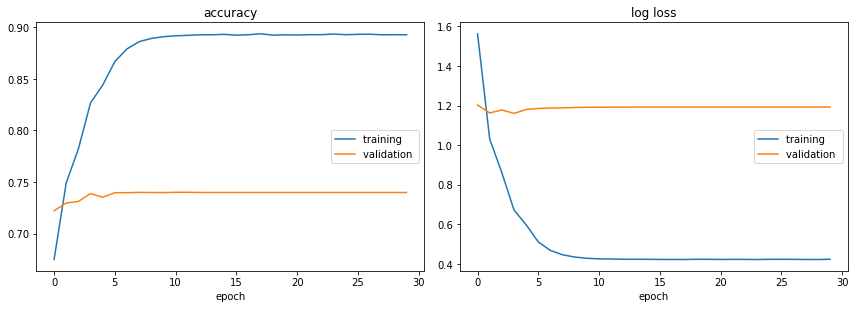

accuracy
	training         	 (min:    0.003, max:    0.982, cur:    0.893)
	validation       	 (min:    0.004, max:    0.789, cur:    0.740)
log loss
	training         	 (min:    0.090, max:    5.298, cur:    0.423)
	validation       	 (min:    0.816, max:    5.298, cur:    1.192)


In [0]:
# for each 30 epoch. Reducing the lr by 1/2
# starting from 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                       factor=0.5, patience=0, verbose=True, 
                                                       threshold=0.001, threshold_mode='rel', 
                                                       cooldown=0, min_lr=0, eps=1e-08)
criterion = nn.CrossEntropyLoss()

for epoch in range(30):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()


    scheduler.step(validation_loss)
    liveloss.update(logs)
    liveloss.draw()

In [0]:
torch.save(model.state_dict(), 'val_train_combined.pt')

In [0]:
# Check macro F1-score for the validation set
from sklearn.metrics import f1_score
model.load_state_dict(torch.load('val_train_combined.pt'))
val_ypred, y_val = evaluate(model, validation_loader)
val_f1 = f1_score(y_val, val_ypred, average='macro')
print(val_f1)

In [0]:
liveloss = PlotLosses()
model = SimpleNet().to(device)

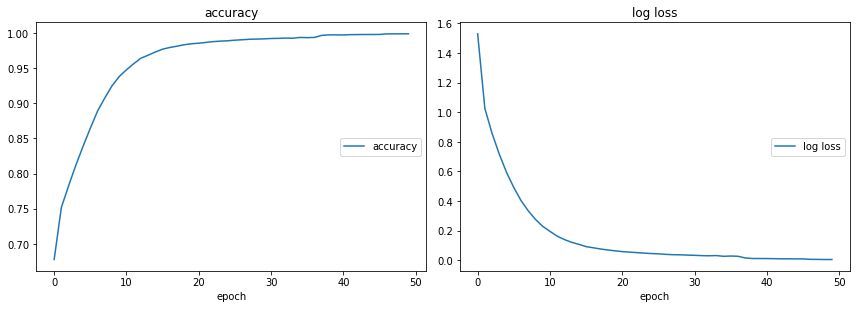

accuracy
	accuracy         	 (min:    0.678, max:    1.000, cur:    0.999)
log loss
	log loss         	 (min:    0.002, max:    1.530, cur:    0.005)


In [0]:
# for each 30 epoch. Reducing the lr by 1/2
# starting from 0.005

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', 
                                                       factor=0.5, patience=3, verbose=True, 
                                                       threshold=0.001, threshold_mode='rel', 
                                                       cooldown=0, min_lr=0, eps=1e-08)
criterion = nn.CrossEntropyLoss()

for epoch in range(50):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_all_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    scheduler.step(train_accuracy)
    liveloss.update(logs)
    liveloss.draw()

In [0]:
torch.save(model.state_dict(), 'all_train_combined.pt')